In [1]:
import pandas as pd
import re
import os
import numpy as np
import gensim
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Convolution1D, MaxPooling1D, LSTM
from keras.layers import Input, Conv1D, MaxPool1D, Bidirectional, GRU
from keras.models import Sequential, Model, load_model


Using TensorFlow backend.


In [2]:
from Attention import AttentionWithContext


In [3]:
def preprocess(text, remove_stop_words = False, stem=True):
    # remove link
    text = re.sub(r"(http?\://|https?\://|www)\S+", " ", str(text).lower()).strip()
    # remove newlines
    text = re.sub(r'\n', ' ', text)
    # remove puctuations and special characters
    text = re.sub(r'\W+', ' ', text)
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # remove first space
    text = re.sub(r'^\s+', '', text)
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    if remove_stop_words or stem:
        tokens = []
        for token in text.split():
            if remove_stop_words:
                if token not in stop_words:
                    if stem:
                        tokens.append(stemmer.stem(token))
                    else:
                        tokens.append(token)
            else:
                if stem:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
        return(" ".join(tokens))
    else:
        return(text)

In [4]:
model = load_model("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v.h5",
                   custom_objects={'AttentionWithContext': AttentionWithContext})

In [5]:
#df = pd.read_csv("../data/test_user200_2021-05-30.csv", encoding = "UTF-8")
#df = pd.read_csv("../data/test_movie_star_1-300_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_1-5000_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_5001-10000_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_10001-15000_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_15001-20000_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/cong_politician_tweets_20210211-20210528_mention_tweets1_text.csv", encoding = "UTF-8")
#df = pd.read_csv("../../dissertation/data/cong_politician_tweets_20210211-20210528_mention_tweets2_text.csv", encoding = "UTF-8")
df = pd.read_csv("../data/test_users_from_profile_text.csv", encoding = "UTF-8")



In [10]:
df.shape

(457833, 5)

In [64]:
df['Party'].isna().sum()

67

In [66]:
## drop NAs
df = df[df['Party'].notna()]

In [7]:
%%time
df.text = df.text.apply(lambda x: preprocess(x, remove_stop_words = False, stem=False))

CPU times: user 9.84 s, sys: 8.99 ms, total: 9.85 s
Wall time: 9.9 s


In [15]:
df.text[8]

''

In [9]:
## drop NAs
df = df[df['text'].notna()]

In [11]:
tokenizer=pickle.load(open("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v_tokenizer.pkl", "rb"))

In [11]:
encoder=pickle.load(open("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v_y-encoder.pkl", "rb"))

In [12]:
SEQUENCE_LENGTH = 50
X = pad_sequences(tokenizer.texts_to_sequences(df.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
#y_true = encoder.transform(df.Party.tolist())

In [13]:
BATCH_SIZE = 512
y_proba = model.predict(X, verbose=1, batch_size=BATCH_SIZE)

457833/457833 [==============================] - 31s 68us/step


In [32]:
y_pred = (y_proba > 0.5).astype("int32")
#f1s = f1_score(y_true, y_pred, average='binary')
#print(f1s)

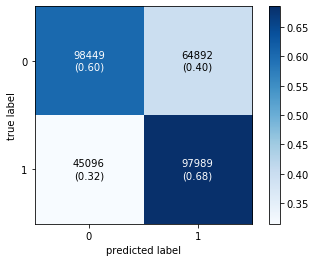

In [45]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
matrix = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [33]:
y_pred_label = encoder.inverse_transform(y_pred)

In [14]:
y_proba[0:10]

array([[0.91602826],
       [0.9664179 ],
       [0.97640646],
       [0.9900273 ],
       [0.71237254],
       [0.8271517 ],
       [0.172019  ],
       [0.10229272],
       [0.5635608 ],
       [0.9996426 ]], dtype=float32)

In [16]:
## remove nested lists
y_proba2 = [ item for elem in y_proba for item in elem]

In [17]:
#pred = pd.DataFrame(data=zip(y_proba2, y_pred_label))
pred = pd.DataFrame(data=y_proba2)

In [18]:
#pred.columns = ['pred_proba', 'pred_label']
pred.columns = ['pred_proba']

In [19]:
pred.shape

(457833, 1)

In [20]:
df.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)

In [21]:
df2 = pd.concat([df[["user_id", "screen_name", "status_id"]], pred], axis=1)

In [22]:
df2

,user_id,screen_name,status_id,pred_proba
0,x1007330705049780224,andres_glr,x1356121939241218057,0.916028
1,x1007330705049780224,andres_glr,x1356121601486499840,0.966418
2,x1007330705049780224,andres_glr,x1356120365605515264,0.976406
3,x1007330705049780224,andres_glr,x1356119784069476358,0.990027
4,x1007330705049780224,andres_glr,x1356119630725701632,0.712373
...,...,...,...,...
457828,x506654741,56mick,x1396067510995324932,0.931018
457829,x506654741,56mick,x1395810746295062532,0.332138
457830,x506654741,56mick,x1395803014062084097,0.199596
457831,x506654741,56mick,x1395802234202566662,0.582100


In [23]:
#df2.to_csv("../data/test_movie_star_1-300_text_pred.csv" ,index = False)
#df2.to_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_1-5000_party_proba.csv" ,index = False)
#df2.to_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_5001-10000_party_proba.csv" ,index = False)
#df2.to_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_10001-15000_party_proba.csv" ,index = False)
#df2.to_csv("../../dissertation/data/election2020_seed_users_tweets_20210131-20210601_15001-20000_party_proba.csv" ,index = False)
#df2.to_csv("../../dissertation/data/cong_politician_tweets_20210211-20210528_mention_tweets1_party_proba.csv" ,index = False)
#df2.to_csv("../../dissertation/data/cong_politician_tweets_20210211-20210528_mention_tweets2_party_proba.csv" ,index = False)
df2.to_csv("../data/test_users_from_profile_party_proba.csv" ,index = False)
